# denoise 2d data with n2v via voila
This notebook is based on [denoising2D_SEM](https://github.com/juglab/n2v/tree/master/examples/2D/denoising2D_SEM) from the GitHub implementation.

When errors occur, ask Niklas or Eric to solve them.

The warnings occuring here are ok.

In [1]:
# We import all our dependencies.

import os
import imageio
import warnings
import numpy as np
import tensorflow as tf
import ipywidgets as widgets
import ipython_blocking
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from ipyfilechooser import FileChooser

from n2v.models import N2VConfig, N2V
from n2v.utils.n2v_utils import manipulate_val_data
from n2v.internals.N2V_DataGenerator import N2V_DataGenerator

from csbdeep.utils import plot_history

# we will restrict usage of GPUs
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

Instructions for updating:
non-resource variables are not supported in the long term


/home/netter/bin/csbdeep/models/__init__.py:20: UserWarning: csbdeep only supports tensorflow 1 behavior for now. We disable v2 behavior (installed tensorflow version: 2.2.0)
  warnings.warn("csbdeep only supports tensorflow 1 behavior for now. We disable v2 behavior (installed tensorflow version: %s)" % _tf_version)


env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


# Which data to denoise?
Click *Select* and choose the correct path of your data, then click *Continue*.

In [2]:
fc = FileChooser('/extdata/readonly/f-prak-v15')
button1 = widgets.Button(description='Continue')
box1 = widgets.VBox(children=[fc, button1])
box1

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [5]:
%blockrun button1

In [6]:
# We create our DataGenerator-object.
# It will help us load data and extract patches for training and validation.
datagen = N2V_DataGenerator()
# We load all the '.tif' files from the 'data' directory.
# If you want to load other types of files see the RGB example.
# The function will return a list of images (numpy arrays).
filelist = []
filelist2 = []
for f in os.listdir(fc.selected_path):
    if f.endswith("tif"):
        filelist.append(os.path.join(fc.selected_path, f))
        filelist2.append(f)
print("Folgende Dateien wurden gefunden:", filelist)
imgs = datagen.load_imgs(filelist)
patch_size = 128
X = datagen.generate_patches_from_list(imgs, shape=(patch_size, patch_size), shuffle=True)

# we choose 15% of patces as validation images

ind = np.random.permutation(X.shape[0])
n_val = max(1, int(round(0.15 * len(ind))))
ind_trn, ind_val = ind[:-n_val], ind[-n_val:]
X_trn = np.empty((len(ind_trn), patch_size, patch_size, 1))
X_val = np.empty((len(ind_val), patch_size, patch_size, 1))
for i, j in enumerate(ind_trn):
    X_trn[i, ...] = X[j, ...]
for i, j in enumerate(ind_val):
    X_val[i, ...] = X[j, ...]

print('number of images: %3d' % X.shape[0])
print('- training:       %3d' % X_trn.shape[0])
print('- validation:     %3d' % X_val.shape[0])

Folgende Dateien wurden gefunden: ['/extdata/share/Niklas/diffusion-data/mutual-information/3different_dyes-20-5-2020/kdv1679_3colorstainingch2endpointxy3c1.tif', '/extdata/share/Niklas/diffusion-data/mutual-information/3different_dyes-20-5-2020/kdv1679_3colorstainingch2endpointxy4c2.tif', '/extdata/share/Niklas/diffusion-data/mutual-information/3different_dyes-20-5-2020/kdv1679_3colorstainingch2endpointxy4c1.tif', '/extdata/share/Niklas/diffusion-data/mutual-information/3different_dyes-20-5-2020/kdv1679_3colorstainingch2endpointxy4c3.tif', '/extdata/share/Niklas/diffusion-data/mutual-information/3different_dyes-20-5-2020/kdv1679_3colorstainingch2endpointxy1c1.tif', '/extdata/share/Niklas/diffusion-data/mutual-information/3different_dyes-20-5-2020/kdv1679_3colorstainingch2endpointxy1c2.tif', '/extdata/share/Niklas/diffusion-data/mutual-information/3different_dyes-20-5-2020/kdv1679_3colorstainingch2endpointxy3c3.tif', '/extdata/share/Niklas/diffusion-data/mutual-information/3different_d

## Data
If the images below look good, go on by clicking *Continue*.

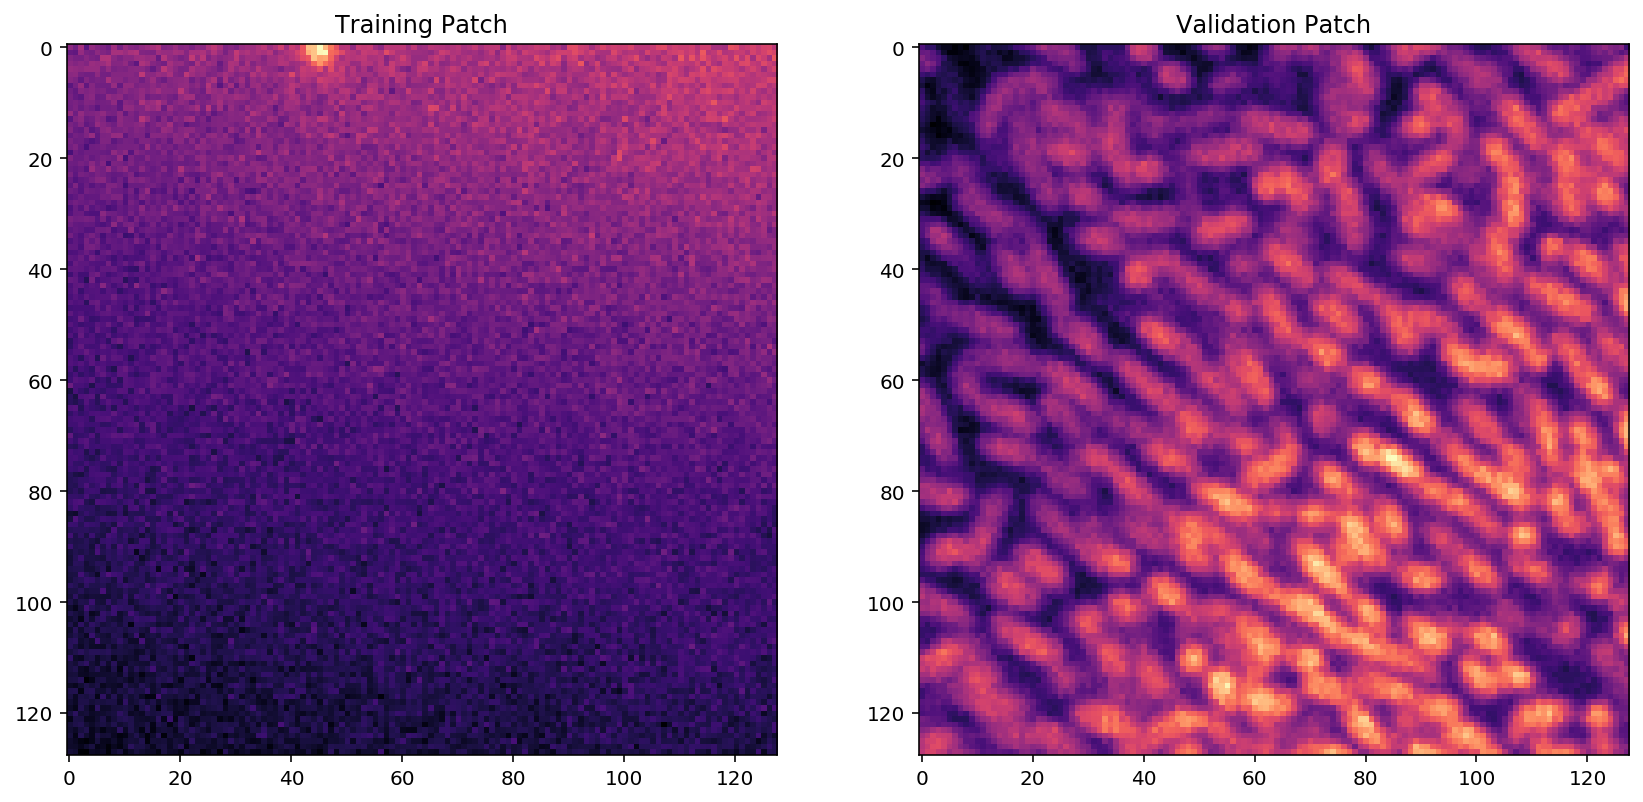

<IPython.core.display.Javascript object>

In [7]:
# Let's look at one of our training and validation patches.
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.imshow(X[0,...,0], cmap='magma')
plt.title('Training Patch');
plt.subplot(1,2,2)
plt.imshow(X_val[0,...,0], cmap='magma')
plt.title('Validation Patch');
button2 = widgets.Button(description='Continue')
box2 = widgets.VBox(children=[button2])
box2

In [10]:
%blockrun button2

# Use a model or train a new model
Do you want to use an existing model or do you want to train a new model for this data? If you want to train a new model provide a name for the model.

In [11]:
basedir = "models"
style = {'description_width': 'initial'}
text = widgets.Text(
    value="",
    description="Name of new model:",
    style=style
)
existing_models = list(os.listdir(basedir))
dropdown = widgets.Dropdown(
    value=None,
    options=existing_models,
    description="select existing model",
    style=style
)
button3 = widgets.Button(description='Continue')
box3 = widgets.VBox(children=[text, dropdown, button3])
box3


<IPython.core.display.Javascript object>

In [14]:
%blockrun button3

In [15]:
new_model_name = text.value
old_model_name = dropdown.value
if (not new_model_name is None) and (new_model_name != ""):
    new_model = True
    model_name = new_model_name
    print("Create new model with name {}".format(new_model_name))
    if not old_model_name is None:
        warnings.warn(
            "When providing both, a name for a new model and an existing model, a new model will be created!",
        )
elif not old_model_name is None:
    print("Using existing model {}".format(old_model_name))
    new_model = False
    model_name = old_model_name
else:
    raise ValueError("No model was chosen")
button4 = widgets.Button(description='Continue')
button4

Create new model with name 100x_mi


Button(description='Continue', style=ButtonStyle())

<IPython.core.display.Javascript object>

In [18]:
%blockrun button4

## Training
If you chose to create a new model, the model first has to be trained for some time (~2 hours).

In [ ]:
# train_steps_per_epoch is set to (number of training patches)/(batch size), like this each training patch 
# is shown once per epoch.
if new_model:
    config = N2VConfig(
        X, unet_kern_size=3, 
        train_steps_per_epoch=int(X.shape[0]/128), train_epochs=100, train_loss='mse', batch_norm=True, 
        train_batch_size=128, n2v_perc_pix=0.198, n2v_patch_shape=(96, 96), 
        n2v_manipulator='uniform_withCP', n2v_neighborhood_radius=5
    )
else:
    config = None
model = N2V(config, model_name, basedir=basedir)
if new_model:
    history = model.train(X, X_val)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
18 blind-spots will be generated per training patch of size (96, 96).


Preparing validation data: 100%|██████████| 922/922 [00:01<00:00, 708.59it/s]

Instructions for updating:
Please use Model.fit, which supports generators.


Epoch 1/100
6144/96 [===================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

6144/96 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

6144/96 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

6144/96 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

6144/96 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

6144/96 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

6144/96 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

6144/96 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

6144/96 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

6144/96 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

6144/96 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

6144/96 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

6144/96 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

6144/96 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

6144/96 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

6144/96 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

6144/96 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

6144/96 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

6144/96 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

6144/96 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Epoch 61/100
6144/96 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

## Test Prediction
Before we denoise all provided images, first check if the network makes reasonable predictions. Check these images and click *Continue* if everything looks good.

In [ ]:
input_val = imgs[:2]
pred_val = [model.predict(x, axes='SYXC') for x in input_val]
slx = slice(400, 600)
sly = slice(400, 600)
slx = sly = slice(None)
# Let's look at the results.
plt.figure(figsize=(16,16))
plt.subplot(2, 2, 1)
plt.title('Input');
plt.imshow(input_val[0][0, sly, slx, 0], cmap="magma")
plt.subplot(2, 2, 3)
plt.imshow(input_val[1][0, sly, slx, 0], cmap="magma")
plt.subplot(2, 2, 2)
plt.title('Prediction');
plt.imshow(pred_val[0][0, sly, slx, 0], cmap="magma")
plt.subplot(2, 2, 4)
plt.imshow(pred_val[1][0, sly, slx, 0], cmap="magma")
button5 = widgets.Button(description='Continue')
button5

In [ ]:
%blockrun button5

In [ ]:
foldername = "denoise_{}".format(model_name)
savepath = os.path.join(fc.selected_path, foldername)
try:
    os.mkdir(savepath)
    run = True
except FileExistsError:
    warnings.warn(
        "Directory {} already exists. Have these files been denoised allready? Delete the folder and rerun!"
    )
    run = False

In [ ]:
if run:
    pred = [model.predict(x, axes='SYXC') for x in imgs]
    for f, im in zip(filelist2, pred):
        p = os.path.join(savepath, f)
        imageio.imwrite(p, im[0, ..., 0])